In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
ls data/

cifar-10-batches-py/    mnist/                  raw/
cifar-10-python.tar.gz  picasso.jpg
dancing.jpg             processed/


In [3]:
!wget http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg

--2017-11-02 09:52:55--  http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org... 192.30.252.153
Connecting to pytorch.org|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K   186KB/s    in 0.6s    

2017-11-02 09:52:56 (186 KB/s) - ‘picasso.jpg’ saved [114573/114573]



In [10]:
!wget http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2017-11-01 17:36:57--  http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org... 192.30.252.153
Connecting to pytorch.org|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K   196KB/s    in 0.2s    

2017-11-01 17:36:58 (196 KB/s) - ‘dancing.jpg’ saved [40484/40484]



In [4]:
!mv picasso.jpg dancing.jpg data

mv: dancing.jpg: No such file or directory


In [5]:
ls data/

cifar-10-batches-py/    mnist/                  raw/
cifar-10-python.tar.gz  picasso.jpg
dancing.jpg             processed/


In [6]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [7]:
print(use_cuda)
print(dtype)

False
<class 'torch.FloatTensor'>


In [8]:
imsize = 512 if use_cuda else 128

loader = transforms.Compose([
        transforms.Scale(imsize),  # 画像サイズを変更する
        transforms.ToTensor()])    # テンソルに変換する（ピクセル値が0-1になるので注意！）

- PyTorchライブラリのニューラルネットは0-1のテンソル画像で訓練されている
- 入力画像が0-255だと意味をなさないので注意！
- Caffeは0-255の画像で訓練されている

In [9]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # バッチの次元を追加
    image = image.unsqueeze(0)
    return image

In [10]:
x = torch.Tensor([1, 2, 3, 4])
print(x)
y = torch.unsqueeze(x, 0)
print(y)
y = torch.unsqueeze(x, 1)
print(y)


 1
 2
 3
 4
[torch.FloatTensor of size 4]


 1  2  3  4
[torch.FloatTensor of size 1x4]


 1
 2
 3
 4
[torch.FloatTensor of size 4x1]



In [11]:
style_img = image_loader('data/picasso.jpg').type(dtype)
content_img = image_loader('data/dancing.jpg').type(dtype)
assert style_img.size() == content_img.size()

In [12]:
print(style_img.size())
print(content_img.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [13]:
style_img

Variable containing:
( 0 , 0 ,.,.) = 
  0.1569  0.1569  0.1529  ...   0.3765  0.3765  0.3882
  0.1725  0.1569  0.1569  ...   0.4235  0.4235  0.4431
  0.1882  0.1647  0.1725  ...   0.4431  0.4471  0.4627
           ...             ⋱             ...          
  0.1529  0.1569  0.1608  ...   0.1765  0.1882  0.1490
  0.1569  0.1608  0.1725  ...   0.1882  0.1765  0.1333
  0.1608  0.1647  0.1765  ...   0.2000  0.1412  0.1294

( 0 , 1 ,.,.) = 
  0.2392  0.2431  0.2431  ...   0.4039  0.4078  0.4196
  0.2627  0.2471  0.2510  ...   0.4431  0.4431  0.4588
  0.2667  0.2431  0.2549  ...   0.4549  0.4549  0.4667
           ...             ⋱             ...          
  0.2275  0.2353  0.2392  ...   0.2235  0.2353  0.1961
  0.2275  0.2314  0.2431  ...   0.2392  0.2314  0.1882
  0.2314  0.2314  0.2471  ...   0.2510  0.2000  0.1882

( 0 , 2 ,.,.) = 
  0.2706  0.2824  0.2863  ...   0.3843  0.3765  0.3804
  0.2824  0.2745  0.2863  ...   0.4196  0.4157  0.4275
  0.2824  0.2667  0.2902  ...   0.4314  0.4314

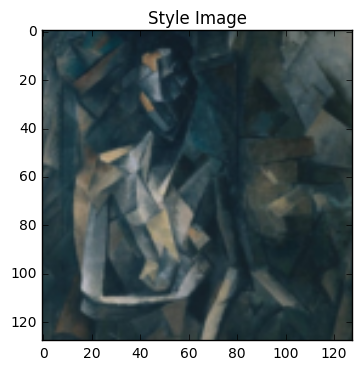

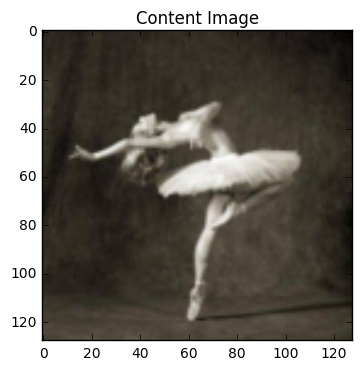

In [14]:
unloader = transforms.ToPILImage()  # PIL imageに戻す
plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()
    # バッチ次元を除く
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

In [15]:
cnn = models.vgg19(pretrained=True)

In [16]:
cnn

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2d (size=(

In [17]:
cnn = models.vgg19(pretrained=True).features

In [18]:
cnn

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU (inplace)
  (18): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (19): Conv2d(256,

In [19]:
if use_cuda:
    cnn = cnn.cuda()

In [20]:
print(cnn[0])
print(cnn[1])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU (inplace)


In [21]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # このtargetはContentLossを計算するための特定層の出力
        # detach()しておくとBPで勾配計算されないので高速になるという理解でよい？
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        # 重み付けした入力をtargetに近づける
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input  # これは何？
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [22]:
class GramMatrix(nn.Module):
    
    def forward(self, input):
        # a = batch size (= 1)
        # b = channel (# of feature maps)
        # (c, d): height x width
        a, b, c, d = input.size()
        
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        # gram matrixを正規化
        return G.div(a * b * c * d)

In [23]:
class StyleLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        # 透過レイヤとして実装（入力をそのまま返す）
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        # targetのGram行列に近づける
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [25]:
# style/content lossを計算するレイヤ
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # なぜここでdeepcopyする？
    # layerをmodelに追加するためか？
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []
    
    # まっさらなモデル（ここにレイヤを追加していく）
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            print(name)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss
                # 層の途中の出力を求める
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                # 既存のレイヤに透過レイヤをContentLossを計算するレイヤをくっつける形で実装
                # transparent layer
                # lossは蓄積されるけど入力がそのまま返される（透過）
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                # style_lossも対象となるレイヤに透過レイヤとしてくっつける
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
        
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            
            # ReLU層が対象になることもある？
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_features = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1
        
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)
    
    return model, style_losses, content_losses

In [26]:
model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
print(model)

conv_1
conv_2
conv_3
conv_4
conv_5
conv_6
conv_7
conv_8
conv_9
conv_10
conv_11
conv_12
conv_13
conv_14
conv_15
conv_16
Sequential (
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss (
    (gram): GramMatrix (
    )
    (criterion): MSELoss (
    )
  )
  (relu_1): ReLU (inplace)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss (
    (gram): GramMatrix (
    )
    (criterion): MSELoss (
    )
  )
  (relu_2): ReLU (inplace)
  (pool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss (
    (gram): GramMatrix (
    )
    (criterion): MSELoss (
    )
  )
  (relu_3): ReLU (inplace)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss (
    (criterion): MSELoss (
    )
  )
  (style_loss_4): StyleLoss (
    (gram)

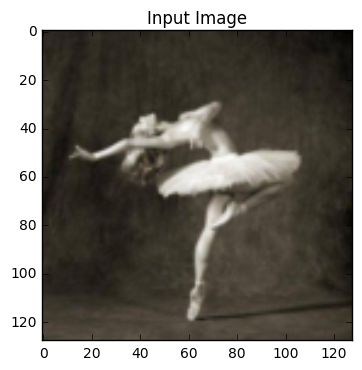

In [27]:
input_img = content_img.clone()
plt.figure()
imshow(input_img.data, title='Input Image')

In [30]:
def get_input_param_optimizer(input_img):
    # 入力画像が更新の対象であるパラメータであることを教える
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [35]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps: 
        print(run[0])
        def closure():
            # 画像の範囲を0から1に制限
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
            
            # backward()はlossそのものを返すように定義
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}:'.format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()
            
            return style_score + content_score
        
        optimizer.step(closure)
    
    input_param.data.clamp_(0, 1)
    return input_param.data

In [40]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

Building the style transfer model..
conv_1
conv_2
conv_3
conv_4
conv_5
conv_6
conv_7
conv_8
conv_9
conv_10
conv_11
conv_12
conv_13
conv_14
conv_15
conv_16
Optimizing..
run [50]:
Style Loss: 2318773.000000 Content Loss: 83.419167

run [100]:
Style Loss: 2318773.000000 Content Loss: 83.419167

run [150]:
Style Loss: 2318773.000000 Content Loss: 83.419167

run [200]:
Style Loss: 2318773.000000 Content Loss: 83.419167

run [250]:
Style Loss: 2318773.000000 Content Loss: 83.419167

run [300]:
Style Loss: 2318773.000000 Content Loss: 83.419167

